In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from network import *
from data import *
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from mpl_finance import candlestick_ohlc



print("Loading : ")
data = load_data(['2018','2019'], 'BTCUSDT', '5m')
#data = load_data(['2019'], 'BTCUSDT', '5m')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\lmacl\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


Loading : 
done


In [7]:


#input data shape
n_variables_past_contiuous = 4
n_variables_future_contiuous = 0
n_variables_past_discrete = [24, 31, 12]
n_variables_future_discrete = [24, 31, 12]

#hyperparams
batch_size = 125
dim_model = 100
n_lstm_layers = 2
n_attention_layers =1
n_heads = 10

quantiles = torch.tensor([0.1, 0.5, 0.9]).float().type(torch.cuda.FloatTensor)

#initialise
t = TFN(n_variables_past_contiuous, n_variables_future_contiuous, 
            n_variables_past_discrete, n_variables_future_discrete, dim_model,
            n_quantiles = quantiles.shape[0], dropout_r = 0.2,
            n_attention_layers = n_attention_layers,n_lstm_layers = n_lstm_layers, n_heads = n_heads).cuda()

optimizer = torch.optim.Adam(t.parameters(), lr=0.0002)

#try to load from checkpoint
path = "model.bruh"
load_model = False

try:
    if(not load_model):
        raise Exception
    checkpoint = torch.load(path)
    t.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    print("Loaded model from checkpoint")
except:    
    print("No checkpoint found, initialising model")


losses = []

No checkpoint found, initialising model


<IPython.core.display.Javascript object>


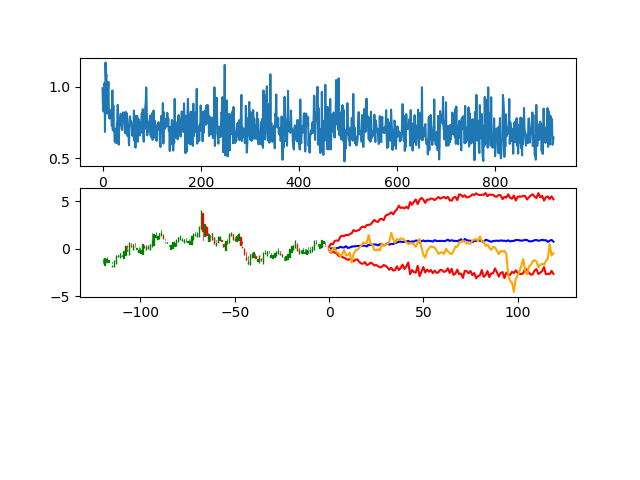

saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved


KeyboardInterrupt: 

In [8]:
#train
past_seq_len = 120
future_seq_len = 120

fig = plt.figure()
#ax = fig.add_subplot(221)
#ax1 = fig.add_subplot(222)
ax = fig.add_subplot(311)
ax1 = fig.add_subplot(312)

#ax1.set_ylim([0,1])
plt.ion()

fig.show()
fig.canvas.draw()

g = get_batches(data, in_seq_len = past_seq_len, out_seq_len = future_seq_len, batch_size = batch_size)

b = False
for e in range(8000):
    for i in t.parameters():
        if(torch.isnan(i).any()):
            b = True
            
    if(b):
        print("nan parameter in network")
        break
    
    #reset gradients and hidden states
    t.reset(batch_size, gpu = True)
    optimizer.zero_grad()
    
    #get batch data
    in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq  = next(g)
    in_seq_discrete = one_hot(in_seq_discrete, [24 ,31 ,12])
    future_in_seq_discrete = one_hot(future_in_seq_discrete, [24 ,31 ,12])
    
    for i in in_seq_discrete:
        if(torch.isnan(i).any() ):
            print("nan discrete input")
            break
        
    if(torch.isnan(in_seq_continuous).any() ):
        print("nan continuous input")
        break
    #forward pass and calculate loss
    net_out = t(in_seq_continuous, in_seq_discrete, None,  future_in_seq_discrete)
    loss = torch.mean(QuantileLoss(net_out, target_seq ,quantiles))
    
    if(torch.isnan(loss).any()):
        print("nan loss")
        break
    
    #save model every 50 batches
    if(e % 50 == 0):
        torch.save({'model_state' : t.state_dict(), 'optimizer_state': optimizer.state_dict()} , "model.bruh")
        print("saved")

    #backwards pass
    losses.append(loss)
    loss.backward()
    optimizer.step()
    
    #draw loss and comparison graphs
    ax1.clear()
    #ax1.set_ylim([0,1])
    
    net_out = net_out.cpu().detach().numpy()[0]
    
    #ax1.plot(list(range(-past_seq_len, 0)), in_seq_continuous[0, : ,0].cpu().detach().numpy())
    
    c = in_seq_continuous[0].cpu()
    a = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((a,c), dim = 1)
    candlestick_ohlc(ax1, c.squeeze(), colorup = "green", colordown = "red")
    
    
    ax1.plot(net_out[:,0], color = "red")
    ax1.plot(net_out[:,1], color = "blue")
    ax1.plot(net_out[:,2], color = "red")
    
    ax1.plot(target_seq.cpu().detach().numpy()[0], label = "target", color = "orange")
    #ax1.legend(loc=1)
    
    
    ax.clear()
    #ax.set_ylim([0,0.5])
    ax.plot(losses)

    fig.canvas.draw()

#print(torch.sum(torch.abs(net_out - y)))
#print(loss)
#print(net_out.shape)

In [ ]:
torch.save({'model_state' : t.state_dict(), 'optimizer_state': optimizer.state_dict()} , "model_8k.bruh")

In [ ]:
t.train()

In [ ]:
test_data = load_data(['2020'], 'BTCUSDT', interval = '5m')


In [ ]:
import time


#test
past_seq_len = 60
future_seq_len = 60
g = get_batches(test_data, in_seq_len = past_seq_len, out_seq_len = future_seq_len, batch_size = 1
                , random_index = True)#, increment = past_seq_len + future_seq_len)

losses = []

mean_loss = 0
i = 0

t.eval()
for in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq in g:
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.ion()

    fig.show()
    fig.canvas.draw()

    in_seq_discrete = one_hot(in_seq_discrete, [24 ,31 ,12])
    future_in_seq_discrete = one_hot(future_in_seq_discrete, [24 ,31 ,12])
    i+=1
    if(i > 20):
        break
    
    t.reset(1, gpu = True)
    #print(in_seq_continuous.shape)
    
    net_out = t(in_seq_continuous, in_seq_discrete, None,  future_in_seq_discrete)
    loss = torch.mean(QuantileLoss(net_out, target_seq ,quantiles))
    losses.append(loss)
    mean_loss += loss
    
    ax.clear()
    
    c = in_seq_continuous[0].cpu()
    a = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((a,c), dim = 1)
    candlestick_ohlc(ax, c.squeeze(), colorup = "green", colordown = "red")
    
    net_out = net_out.cpu().detach().numpy()[0]
    ax.plot(net_out[:,0], color = "red")
    ax.plot(net_out[:,1], color = "blue")
    ax.plot(net_out[:,2], color = "red")
    
    ax.plot(target_seq.cpu().detach().numpy()[0], label = "target", color = "orange")
    fig.canvas.draw()

    #time.sleep(1)
    
print(mean_loss / (i+1))    

In [ ]:
g = get_batches(data, in_seq_len = past_seq_len, out_seq_len = future_seq_len, batch_size = 1)



In [ ]:
b = []
for i in range(100):
    b.append(next(g)[0][0,:,0].cpu().numpy())

In [ ]:
for i in b:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(i)
#print(b)

In [ ]:
print(b[13])